# Hip Hop Lyrics EDA and Exploration

In [20]:
from pymongo import MongoClient
from bson.objectid import ObjectId

In [21]:
# pull data from mongo to get a list of artists and their song lyrics
client = MongoClient()

In [22]:
mack_dev = client['mack']

In [23]:
musician_dev = mack_dev['musician']
song_dev = mack_dev['song']
album_dev = mack_dev['album']

In [24]:
# find all songs that successfully have lyrics
song_cursor = song_dev.find({'lyrics': {'$exists': True, '$nin': ['No Result','AttributeError', 'TypeError']}})

In [25]:
song_list = [song for song in song_cursor]

In [30]:
# how many songs do we have?
len(song_list)

50908

In [27]:
# how many distinct artists do we have
len(set([song['musician_id'] for song in song_list]))

1113

In [31]:
# lets check how long it will take for our lyrics to be collected

In [32]:
process_times = [song['process_time'] for song in song_list]

In [49]:
time_to_complete_gathering = sum(process_times) / 60 / 60 / 24

In [50]:
print round(time_to_complete_gathering), ' days'

1.0  days


In [51]:
# oh boy that's a long time

# Let's try some NLP with our EDA

In [52]:
# write functions to clean and tokenize lyrics
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from string import punctuation

def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

def tokenize_lyrics(s):
    lyrics = s.lower().split()
    lyrics = [word for word in lyrics if word.find('[') == -1]
    lyrics = [word for word in lyrics if word.find(']') == -1]
    lyrics = [strip_punctuation(s) for s in lyrics]
    return lyrics

def lemmatize_word(word):
    wordnet = WordNetLemmatizer()
    lemmatized_word = wordnet.lemmatize(word)
    return lemmatized_word

# def tokenize(doc):
#     return [wordnet.lemmatize(word) for word in nltk.word_tokenize(doc.lower())]

def tokenize(s):
    return [lemmatize_word(word) for word in tokenize_lyrics(s)]

In [53]:
# create a document of all lyrics to create a vocabulary
all_lyrics = [song['lyrics'] for song in song_list]
all_lyrics_string = ' '.join(all_lyrics)

In [54]:
# lets take a peak at the total vocabulary
tokenized_vocabulary = tokenize_lyrics(all_lyrics_string)

In [55]:
count_unique_words = len(set(tokenized_vocabulary))

In [56]:
count_unique_words

244984

In [57]:
# lets take a peak at the total lemmatized vocabulary
lemmatized_vocabulary = [lemmatize_word(word) for word in tokenized_vocabulary]

In [58]:
count_unique_lem_words = len(set(lemmatized_vocabulary))

In [59]:
count_unique_lem_words

233865

In [60]:
# create a list of all artists and their lyrics
artist_song_list = []
for song in song_list:
    musician_id = song['musician_id']
    song_id = song['_id']
    song_name = song['spotify_track_data']['name']
    musician_name = musician_dev.find_one({'_id': musician_id})['musician_name']
    lyrics = song['lyrics']
    artist_song_list.append((musician_id, musician_name, song_id, song_name, lyrics))

In [61]:
import pandas as pd
import numpy as np

In [62]:
# lets create a dataframe of our data
columns = ['musician_id', 'musician_name', 'song_id', 'song_name', 'lyrics']
df = pd.DataFrame.from_records(data=artist_song_list, columns=columns)

In [63]:
df.head()

,musician_id,musician_name,song_id,song_name,lyrics
0,58212da6e228c35b02d5c030,100s,5823c40be228c38897ffa947,My Activator,"\n\n""Back up!""\n""Back up, back up, back up...""..."
1,58212da6e228c35b02d5c030,100s,5823c40be228c38897ffa948,Brick $ell Phone,\n\n[Verse 1]\n(It's that 5th floor...)\n\nTel...
2,58212da6e228c35b02d5c030,100s,5823c40ce228c38897ffa949,Slow Drip,"\n\n[Verse 1]\nAt it again in that le Sabre, m..."
3,58212da6e228c35b02d5c030,100s,5823c40ce228c38897ffa94b,Land of The Laced,\n\n[Intro]\nCry two tears in a bucket...\nFuc...
4,58212da6e228c35b02d5c030,100s,5823c40ce228c38897ffa94c,Closer (feat. Mondre MAN),"\n\n[Intro: MondreMAN]\nYeah, yeah, Joe S what..."


In [64]:
# create a dataframe of just artists and their lyrics
lyrics_by_artist_series = df[['musician_name','lyrics']].groupby('musician_name')['lyrics'].apply(lambda x: ' '.join(x))

In [65]:
# lets take a peak
lyrics_by_artist_df = pd.Series.to_frame(lyrics_by_artist_series)
lyrics_by_artist_df.reset_index(inplace=True)
lyrics_by_artist_df.head()

,musician_name,lyrics
0,100s,"\n\n""Back up!""\n""Back up, back up, back up...""..."
1,112,"\n\n[Slim (Foxy Brown]\nUh, 112 (Foxy)\nUh, (1..."
2,1200 Techniques,"\n\n[DJ Peril]\nNfamous - step, step, step, st..."
3,2 Chainz,"\n\n[Intro]\nCheck me out now\n\n[Hook]\nYeah,..."
4,2 Live Crew,\n\n( ) = Mixx's lines during verses\n\nIntro:...


In [66]:
len(lyrics_by_artist_df)

1112

In [67]:
# the moment we've all been waiting for lets vectorize this bad boy!

In [68]:
vectorizer = TfidfVectorizer(stop_words='english', tokenizer=tokenize)
vectors = vectorizer.fit_transform(lyrics_by_artist_df['lyrics']).toarray()

In [69]:
feature_words = vectorizer.get_feature_names()

In [33]:
feature_words[500:1500]

[u'30003000',
 u'3000s',
 u'3001',
 u'300g',
 u'300k',
 u'301',
 u'3030',
 u'303rd',
 u'304',
 u'304s',
 u'305',
 u'305s',
 u'30k',
 u'30round',
 u'30something',
 u'30th',
 u'30year',
 u'30years',
 u'30\u2019s',
 u'31',
 u'310',
 u'311',
 u'312',
 u'31276210',
 u'313',
 u'313s',
 u'314',
 u'31558464000',
 u'316',
 u'31s',
 u'31st',
 u'32',
 u'320',
 u'321',
 u'321456',
 u'322',
 u'323',
 u'324',
 u'325',
 u'33',
 u'330',
 u'330055',
 u'336',
 u'34',
 u'342036',
 u'34th',
 u'34ths',
 u'35',
 u'350',
 u'35000',
 u'350you',
 u'355',
 u'357',
 u'35hundred',
 u'35th',
 u'35ths',
 u'36',
 u'360',
 u'362436',
 u'365',
 u'365\u306e\u65e5\u5e38',
 u'36th',
 u'37',
 u'38',
 u'380',
 u'380s',
 u'382437',
 u'38s',
 u'38th',
 u'38\u2019s',
 u'39',
 u'390',
 u'399',
 u'3999',
 u'3a',
 u'3am',
 u'3big',
 u'3celph',
 u'3d',
 u'3d2',
 u'3do',
 u'3doap',
 u'3e',
 u'3g',
 u'3hree',
 u'3hundred',
 u'3hunna',
 u'3inch',
 u'3j52',
 u'3jamie',
 u'3k',
 u'3krazy',
 u'3nate',
 u'3o',
 u'3one',
 u'3p',
 u'3pack

In [70]:
# so we can see a bunch of mispellings. Not sure if we can attribute this to the musician or
# to where ever / whomever genius gets their lyrics from
# there is a risk our dimensionality reduction could mearly discover these "bad" sources as
# a hidden feature

# FSM - Modeling

In [72]:
# Let's try NMF then LDA

from sklearn.decomposition import NMF
n_topics = 30

def reconst_mse(target, left, right):
    return (np.array(target - left.dot(right))**2).mean()

def describe_nmf_results(document_term_mat, W, H, n_top_words = 15):
    print("Reconstruction error: %f") %(reconst_mse(document_term_mat, W, H))
    for topic_num, topic in enumerate(H):
        print("Topic %d:" % topic_num)
        print(" ".join([feature_words[i] \
                for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [73]:
nmf = NMF(n_components=n_topics)
W_sklearn = nmf.fit_transform(vectors)
H_sklearn = nmf.components_
describe_nmf_results(vectors, W_sklearn, H_sklearn)

Reconstruction error: 0.000003
Topic 0:
im dont just thats aint cause like ive ill feel think better imma time need
Topic 1:
nigga fuck shit bitch aint know im gon money em dont real young bout make
Topic 2:
le à je et dans que pa qui la cest est comme en mais tu
Topic 3:
girl love baby wanna oh let want know just make hey time come youre like
Topic 4:
i’m don’t it’s ain’t like that’s just know can’t i’ll you’re ‘em say tell i’ve
Topic 5:
got money im aint like man just girl young trap tryna shit gotta new cash
Topic 6:
que y en el mi te tu por lo se la para como e los
Topic 7:
like know im make ya beat flow  rap style hit wa new got car
Topic 8:
und ich ist der nicht wir du wie auf sie mit zu für die ein
Topic 9:
je se za sve da ne sam ja kad na mi ko smo samo ti
Topic 10:
bitch hoe lil pussy dick imma ho fuck like money aint yo know dont bad
Topic 11:
난 내 내가 다 날 넌 이 더 나의 수 또 안 나는 그 니
Topic 12:
yo yall im shit got wit ya man street thats rap black uh wa aint
Topic 13:
cause rhyme im m

In [99]:
# I found out we have some musicians from different languages I need to take into account
# Based on this realization and advise from instructors, I'll adjust my project
# to only focus on Musicians who only speak english

In [40]:
musician_dev.find_one({})['spotify_data']['genres']

[u'bulgarian rock', u'chalga']

In [41]:
musicians = [musician for musician in musician_dev.find({'spotify_data': {'$exists': True, '$nin': ['No Results']}})]

In [42]:
genres = [musician['spotify_data']['genres'] for musician in musicians]

In [43]:
genres

[[u'bulgarian rock', u'chalga'],
 [u'j-dance', u'j-indie', u'j-rock', u'underground hip hop'],
 [],
 [u'pop rap', u'rap', u'southern hip hop', u'trap music'],
 [u'crunk',
  u'dirty south rap',
  u'gangster rap',
  u'hip pop',
  u'pop rap',
  u'rap',
  u'southern hip hop',
  u'trap music'],
 [],
 [u'dwn trap', u'trap music'],
 [u'abstract hip hop', u'underground rap'],
 [u'deep regional mexican'],
 [u'gangster rap', u'hyphy', u'pop rap'],
 [u'crunk',
  u'dance pop',
  u'dirty south rap',
  u'east coast hip hop',
  u'gangster rap',
  u'hip hop',
  u'hip pop',
  u'pop rap',
  u'rap',
  u'trap music'],
 [],
 [],
 [u'alternative hip hop', u'hip hop'],
 [],
 [],
 [u'alternative hip hop',
  u'escape room',
  u'hip hop',
  u'indie r&b',
  u'pop rap',
  u'rap',
  u'southern hip hop',
  u'trap music',
  u'underground hip hop'],
 [u'abstract hip hop', u'underground rap'],
 [u'crunk',
  u'dirty south rap',
  u'gangster rap',
  u'hip hop',
  u'pop rap',
  u'rap',
  u'southern hip hop',
  u'trap mus

In [44]:
song_dev.find_one({'genius_data': {'$exists': True, '$nin': ['No Result','AttributeError', 'TypeError']}})

{u'_id': ObjectId('5823c40be228c38897ffa947'),
 u'audio_features': [{u'acousticness': 0.129,
   u'analysis_url': u'https://api.spotify.com/v1/audio-analysis/6s76y7zMZ82FicL21wuhaj',
   u'danceability': 0.798,
   u'duration_ms': 214167,
   u'energy': 0.447,
   u'id': u'6s76y7zMZ82FicL21wuhaj',
   u'instrumentalness': 0,
   u'key': 5,
   u'liveness': 0.087,
   u'loudness': -12.141,
   u'mode': 0,
   u'speechiness': 0.389,
   u'tempo': 143.911,
   u'time_signature': 4,
   u'track_href': u'https://api.spotify.com/v1/tracks/6s76y7zMZ82FicL21wuhaj',
   u'type': u'audio_features',
   u'uri': u'spotify:track:6s76y7zMZ82FicL21wuhaj',
   u'valence': 0.495}],
 u'genius_data': {u'highlights': [],
  u'index': u'song',
  u'result': {u'annotation_count': 31,
   u'api_path': u'/songs/211725',
   u'full_title': u'My Activator by\xa0100s',
   u'header_image_thumbnail_url': u'https://s3.amazonaws.com/rapgenius/a4228093635_10.jpg',
   u'header_image_url': u'https://s3.amazonaws.com/rapgenius/a4228093635_1

In [45]:
album_dev.find_one({})

{u'_id': ObjectId('5823c406e228c38897ffa920'),
 u'musician_id': ObjectId('58212da6e228c35b02d5c02f'),
 u'spotify_album_data': {u'album_type': u'single',
  u'artists': [{u'external_urls': {u'spotify': u'https://open.spotify.com/artist/2KgSliKOckorQuEHjAa15V'},
    u'href': u'https://api.spotify.com/v1/artists/2KgSliKOckorQuEHjAa15V',
    u'id': u'2KgSliKOckorQuEHjAa15V',
    u'name': u'Fang',
    u'type': u'artist',
    u'uri': u'spotify:artist:2KgSliKOckorQuEHjAa15V'},
   {u'external_urls': {u'spotify': u'https://open.spotify.com/artist/1eSLQvCYcfd5f1jgxBGbKJ'},
    u'href': u'https://api.spotify.com/v1/artists/1eSLQvCYcfd5f1jgxBGbKJ',
    u'id': u'1eSLQvCYcfd5f1jgxBGbKJ',
    u'name': u'100 Kila',
    u'type': u'artist',
    u'uri': u'spotify:artist:1eSLQvCYcfd5f1jgxBGbKJ'}],
  u'available_markets': [u'AD',
   u'AR',
   u'AT',
   u'AU',
   u'BE',
   u'BG',
   u'BO',
   u'BR',
   u'CA',
   u'CH',
   u'CL',
   u'CO',
   u'CR',
   u'CY',
   u'CZ',
   u'DE',
   u'DK',
   u'DO',
   u'EC',


# Apply "topics" to artists

In [74]:
# so far I haven't found a single piece of metadata that gives me a good language filter
# I'm wondering if my next step should be to identify the songs of different languages
# using the stop words from nltk or a language identifying package

In [75]:
# for the first pass at the project I'll ignore the above and move onto classifying my artists by topic

# notes for using cosine similarity
# from sklearn.metrics.pairwise import cosine_similarity
# cosine_similarity(W_sklearn[0:1], W_sklearn)

In [76]:
# lets create a list of the topics for every artist
artist_topics = [artist.argmax() for artist in W_sklearn]

# Visualize grouped artists

In [77]:
# lets take at our topic distributions
import matplotlib.pyplot as plt
%matplotlib inline

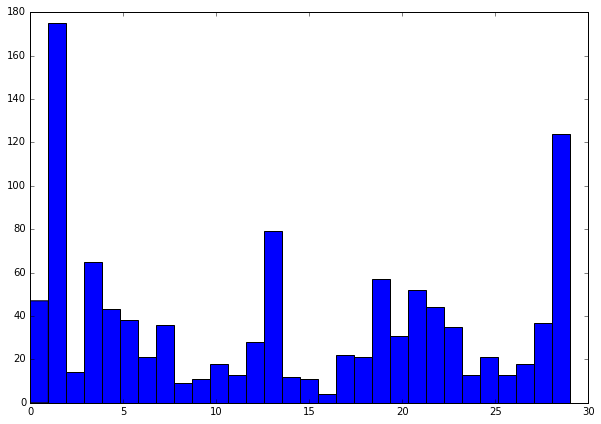

In [78]:
# plot topic distributions
plt.figure(figsize=(10,7))
plt.hist(artist_topics, bins=30)
plt.show()

In [79]:
# seems Topic 1 is by far the most dominant class

In [80]:
artist_and_topic = []
for i in xrange(len(artist_topics)):
    artist_and_topic.append((lyrics_by_artist_df['musician_name'][i], artist_topics[i]))

In [81]:
artist_topic_df = pd.DataFrame.from_records(data=artist_and_topic,columns=[['musician_name','topic']])

# Explore Artist Groups

In [82]:
artist_topic_df.head()

,musician_name,topic
0,100s,1
1,112,29
2,1200 Techniques,5
3,2 Chainz,5
4,2 Live Crew,13


In [83]:
# lets create a dictionary of top words per topic
topic_dict = {}
for topic_num, topic in enumerate(H_sklearn):
        topic_dict[topic_num] = " ".join([feature_words[i] for i in topic.argsort()[:-15 - 1:-1]])

In [84]:
topic_dict

{0: u'im dont just thats aint cause like ive ill feel think better imma time need',
 1: u'nigga fuck shit bitch aint know im gon money em dont real young bout make',
 2: u'le \xe0 je et dans que pa qui la cest est comme en mais tu',
 3: u'girl love baby wanna oh let want know just make hey time come youre like',
 4: u'i\u2019m don\u2019t it\u2019s ain\u2019t like that\u2019s just know can\u2019t i\u2019ll you\u2019re \u2018em say tell i\u2019ve',
 5: u'got money im aint like man just girl young trap tryna shit gotta new cash',
 6: u'que y en el mi te tu por lo se la para como e los',
 7: u'like know im make ya beat flow  rap style hit wa new got car',
 8: u'und ich ist der nicht wir du wie auf sie mit zu f\xfcr die ein',
 9: u'je se za sve da ne sam ja kad na mi ko smo samo ti',
 10: u'bitch hoe lil pussy dick imma ho fuck like money aint yo know dont bad',
 11: u'\ub09c \ub0b4 \ub0b4\uac00 \ub2e4 \ub0a0 \ub10c \uc774 \ub354 \ub098\uc758 \uc218 \ub610 \uc548 \ub098\ub294 \uadf8 \ub2c8'

In [87]:
artist_topic_df.head()

,musician_name,topic
0,100s,1
1,112,29
2,1200 Techniques,5
3,2 Chainz,5
4,2 Live Crew,13


In [90]:
song_dev.find({})

In [104]:
artist_topic_df[['musician_name','topic']][:]

,musician_name,topic
0,100s,1
1,112,29
2,1200 Techniques,5
3,2 Chainz,5
4,2 Live Crew,13
5,2 Pistols,5
6,2 Skinnee J's,7
7,21 Savage,1
8,2Mex,19
9,2nd II None,22


# Visualization Example Code

In [12]:
# cluster_colors = {0: '#CCFFCC', 1: '#CCFFFF', 2: '#FFFF99', 3: '#CCCC66', 4: '#FFFF00', \
#                   5: '#CCCCFF', 6: '#CCCCCC', 7: '#FFCCCC', 8: '#FFCC99', 9: '#FFCC00', \
#                   10: '#CC9966', 11: '#FF99FF', 12: '#FF9900', 13: '#CC6633', 14: '#FF6600', \
#                   15: '#CC3333', 16: '#FF3366',  17: '#660066', 18: '#660000', 19: '#6600FF', \
#                   20: '#663300', 21: '#666600', 22: '#6666FF', 23: '#669900', 24: '#669999', \
#                   25: '#6699CC', 26: '#66CC00', 27: '#00FF33',28: '#006666',29: '#000000'}cluster_colors = {0: '#CCFFCC', 1: '#CCFFFF', 2: '#FFFF99', 3: '#CCCC66', 4: '#FFFF00', \
#                   5: '#CCCCFF', 6: '#CCCCCC', 7: '#FFCCCC', 8: '#FFCC99', 9: '#FFCC00', \
#                   10: '#CC9966', 11: '#FF99FF', 12: '#FF9900', 13: '#CC6633', 14: '#FF6600', \
#                   15: '#CC3333', 16: '#FF3366',  17: '#660066', 18: '#660000', 19: '#6600FF', \
#                   20: '#663300', 21: '#666600', 22: '#6666FF', 23: '#669900', 24: '#669999', \
#                   25: '#6699CC', 26: '#66CC00', 27: '#00FF33',28: '#006666',29: '#000000'}

In [10]:
# cluster_colors

In [9]:
# groups = artist_topic_df.groupby('topic')

In [8]:
# fig, ax = plt.subplots(figsize=(10, 5)) # set size
# ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
# N = 30
# data = np.random.random((N, 4))
# labels = ['point{0}'.format(i) for i in range(N)]
# plt.subplots_adjust(bottom = 0.1)
# plt.scatter(
#     data[:, 0], data[:, 1], marker = 'o', c = data[:, 2], s = data[:, 3]*1500,
#     cmap = plt.get_cmap('Spectral'))
# for label, x, y in zip(labels, data[:, 0], data[:, 1]):
#     plt.annotate(
#         label, 
#         xy = (x, y), xytext = (-20, 20),
#         textcoords = 'offset points', ha = 'right', va = 'bottom',
#         bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
#         arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

# plt.show()

In [7]:
# from matplotlib.pyplot import figure, show
# import numpy as npy
# from numpy.random import rand

# if 1: # picking on a scatter plot (matplotlib.collections.RegularPolyCollection)

#     x, y, c, s = rand(4, 100)
#     def onpick3(event):
#         ind = event.ind
#         print 'onpick3 scatter:', ind, npy.take(x, ind), npy.take(y, ind)

#     fig, ax1 = plt.subplots(figsize=(10, 5)) # set size
#     ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
#     ax1 = fig.add_subplot(111)
#     col = ax1.scatter(x, y, 100*s, c, picker=True)
#     #fig.savefig('pscoll.eps')
#     fig.canvas.mpl_connect('pick_event', onpick3)

# show()

In [6]:
# import matplotlib.pyplot as plt
# import scipy.spatial as spatial
# import numpy as np
# pi = np.pi
# cos = np.cos

# def fmt(x, y):
#     return 'x: {x:0.2f}\ny: {y:0.2f}'.format(x=x, y=y)

# class FollowDotCursor(object):
#     """Display the x,y location of the nearest data point.
#     http://stackoverflow.com/a/4674445/190597 (Joe Kington)
#     http://stackoverflow.com/a/13306887/190597 (unutbu)
#     http://stackoverflow.com/a/15454427/190597 (unutbu)
#     """
#     def __init__(self, ax, x, y, tolerance=5, formatter=fmt, offsets=(-20, 20)):
#         try:
#             x = np.asarray(x, dtype='float')
#         except (TypeError, ValueError):
#             x = np.asarray(mdates.date2num(x), dtype='float')
#         y = np.asarray(y, dtype='float')
#         mask = ~(np.isnan(x) | np.isnan(y))
#         x = x[mask]
#         y = y[mask]
#         self._points = np.column_stack((x, y))
#         self.offsets = offsets
#         y = y[np.abs(y-y.mean()) <= 3*y.std()]
#         self.scale = x.ptp()
#         self.scale = y.ptp() / self.scale if self.scale else 1
#         self.tree = spatial.cKDTree(self.scaled(self._points))
#         self.formatter = formatter
#         self.tolerance = tolerance
#         self.ax = ax
#         self.fig = ax.figure
#         self.ax.xaxis.set_label_position('top')
#         self.dot = ax.scatter(
#             [x.min()], [y.min()], s=130, color='green', alpha=0.7)
#         self.annotation = self.setup_annotation()
#         plt.connect('motion_notify_event', self)

#     def scaled(self, points):
#         points = np.asarray(points)
#         return points * (self.scale, 1)

#     def __call__(self, event):
#         ax = self.ax
#         # event.inaxes is always the current axis. If you use twinx, ax could be
#         # a different axis.
#         if event.inaxes == ax:
#             x, y = event.xdata, event.ydata
#         elif event.inaxes is None:
#             return
#         else:
#             inv = ax.transData.inverted()
#             x, y = inv.transform([(event.x, event.y)]).ravel()
#         annotation = self.annotation
#         x, y = self.snap(x, y)
#         annotation.xy = x, y
#         annotation.set_text(self.formatter(x, y))
#         self.dot.set_offsets((x, y))
#         bbox = ax.viewLim
#         event.canvas.draw()

#     def setup_annotation(self):
#         """Draw and hide the annotation box."""
#         annotation = self.ax.annotate(
#             '', xy=(0, 0), ha = 'right',
#             xytext = self.offsets, textcoords = 'offset points', va = 'bottom',
#             bbox = dict(
#                 boxstyle='round,pad=0.5', fc='yellow', alpha=0.75),
#             arrowprops = dict(
#                 arrowstyle='->', connectionstyle='arc3,rad=0'))
#         return annotation

#     def snap(self, x, y):
#         """Return the value in self.tree closest to x, y."""
#         dist, idx = self.tree.query(self.scaled((x, y)), k=1, p=1)
#         try:
#             return self._points[idx]
#         except IndexError:
#             # IndexError: index out of bounds
#             return self._points[0]

# fig, ax = plt.subplots()
# x = np.linspace(0.1, 2*pi, 10)
# y = cos(x)
# markerline, stemlines, baseline = ax.stem(x, y, '-.')
# plt.setp(markerline, 'markerfacecolor', 'b')
# plt.setp(baseline, 'color','r', 'linewidth', 2)
# cursor = FollowDotCursor(ax, x, y, tolerance=20)
# plt.show()

In [5]:
# import mpld3

# mpld3.enable_notebook()

In [4]:
# fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'),figsize=(10, 5))
# ax.grid(color='white', linestyle='solid')
# ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# N = 50
# scatter = ax.scatter(np.random.normal(size=N),
#                      np.random.normal(size=N),
#                      c=np.random.random(size=N),
#                      s = 1000 * np.random.random(size=N),
#                      alpha=0.3,
#                      cmap=plt.cm.jet)

# ax.set_title("D3 Scatter Plot", size=18)

In [3]:
# from mpld3 import plugins

# fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'))
# ax.grid(color='white', linestyle='solid')

# N = 50
# scatter = ax.scatter(np.random.normal(size=N),
#                      np.random.normal(size=N),
#                      c=np.random.random(size=N),
#                      s = 1000 * np.random.random(size=N),
#                      alpha=0.3,
#                      cmap=plt.cm.jet)

# ax.set_title("D3 Scatter Plot (with tooltips!)", size=20)

# labels = ['point {0}'.format(i + 1) for i in range(N)]
# fig.plugins = [plugins.PointLabelTooltip(scatter, labels)]

In [2]:
# scatter

In [1]:
# from bokeh.models import HoverTool, ColumnDataSource
# from bokeh.plotting import figure, show
# from bokeh.sampledata.periodic_table import elements

# romans = ["I", "II", "III", "IV", "V", "VI", "VII"]

# elements["atomic mass"] = elements["atomic mass"].astype(str)

# elements["period"] = [romans[x-1] for x in elements.period]
# elements = elements[elements.group != "-"]

# group_range = [str(x) for x in range(1, 19)]

# colormap = {
#     "alkali metal"         : "#a6cee3",
#     "alkaline earth metal" : "#1f78b4",
#     "halogen"              : "#fdbf6f",
#     "metal"                : "#b2df8a",
#     "metalloid"            : "#33a02c",
#     "noble gas"            : "#bbbb88",
#     "nonmetal"             : "#baa2a6",
#     "transition metal"     : "#e08e79",
# }

# source = ColumnDataSource(
#     data=dict(
#         group=[str(x) for x in elements["group"]],
#         period=[str(y) for y in elements["period"]],
#         symx=[str(x)+":0.1" for x in elements["group"]],
#         numbery=[str(x)+":0.8" for x in elements["period"]],
#         massy=[str(x)+":0.15" for x in elements["period"]],
#         namey=[str(x)+":0.3" for x in elements["period"]],
#         sym=elements["symbol"],
#         name=elements["name"],
#         cpk=elements["CPK"],
#         atomic_number=elements["atomic number"],
#         electronic=elements["electronic configuration"],
#         mass=elements["atomic mass"],
#         type=elements["metal"],
#         type_color=[colormap[x] for x in elements["metal"]],
#     )
# )

# p = figure(title="Periodic Table", tools="hover,save",
#            x_range=group_range, y_range=list(reversed(romans)))
# p.plot_width = 1200
# p.toolbar_location = None
# p.outline_line_color = None

# p.rect("group", "period", 0.9, 0.9, source=source,
#        fill_alpha=0.6, color="type_color")

# text_props = {
#     "source": source,
#     "angle": 0,
#     "color": "black",
#     "text_align": "left",
#     "text_baseline": "middle"
# }

# p.text(x="symx", y="period", text="sym",
#        text_font_style="bold", text_font_size="15pt", **text_props)

# p.text(x="symx", y="numbery", text="atomic_number",
#        text_font_size="9pt", **text_props)

# p.text(x="symx", y="namey", text="name",
#        text_font_size="6pt", **text_props)

# p.text(x="symx", y="massy", text="mass",
#        text_font_size="5pt", **text_props)

# p.grid.grid_line_color = None

# p.select_one(HoverTool).tooltips = [
#     ("name", "@name"),
#     ("atomic number", "@atomic_number"),
#     ("type", "@type"),
#     ("atomic mass", "@mass"),
#     ("CPK color", "$color[hex, swatch]:cpk"),
#     ("electronic configuration", "@electronic"),
# ]

# show(p)  # Change to save(p) to save but not show the HTML file